# Algotrading
***Iago Domingues***

Baseado no notebook disponibilizado por Marina Barbosa

O arquivo contém dados de todos os ativos negociados na BOVESPA, então para facilitar o acesso de cada ativo vamos agrupá-los de acordo com seu código.

As features de cada ativo são:
- codigo
- fechamento_atual
- abertura
- maximo
- minimo
- fechamento_anterior
- negocios
- quantidade_papeis
- volume_financeiro
- datahora

In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_FILE = "200801-a-20180526_candles_ibov_15min-tratado-cabecalho-10campos.txt"

# read data 
full_data = pd.read_csv(
    DATA_FILE,
    parse_dates=["datahora"],
    date_parser=lambda x: pd.datetime.strptime(x, '%Y%m%d%H%M'))

grouped_data = full_data.groupby("codigo", as_index=False)    

Quanto mais dados (de qualidade) temos, mais o nosso modelo poderá aprender, já que ele terá mais exemplos para derivar as estatísticas.

Então para nos ajudar a visualizar e escolher a melhor série para o nosso modelo, vamos ordenar os ativos de acordo com o número de candles que ele possui.

In [3]:
sorted_grouped_data = sorted(
    grouped_data,  # iterates pairs of (key, corresponding subDataFrame)
    key=lambda x: len(x[1]),  # sort by number of rows (len of subDataFrame)
    reverse=True  # largest first
)

Vamos observar a distribuição dos preços de fechamento através de histogramas.

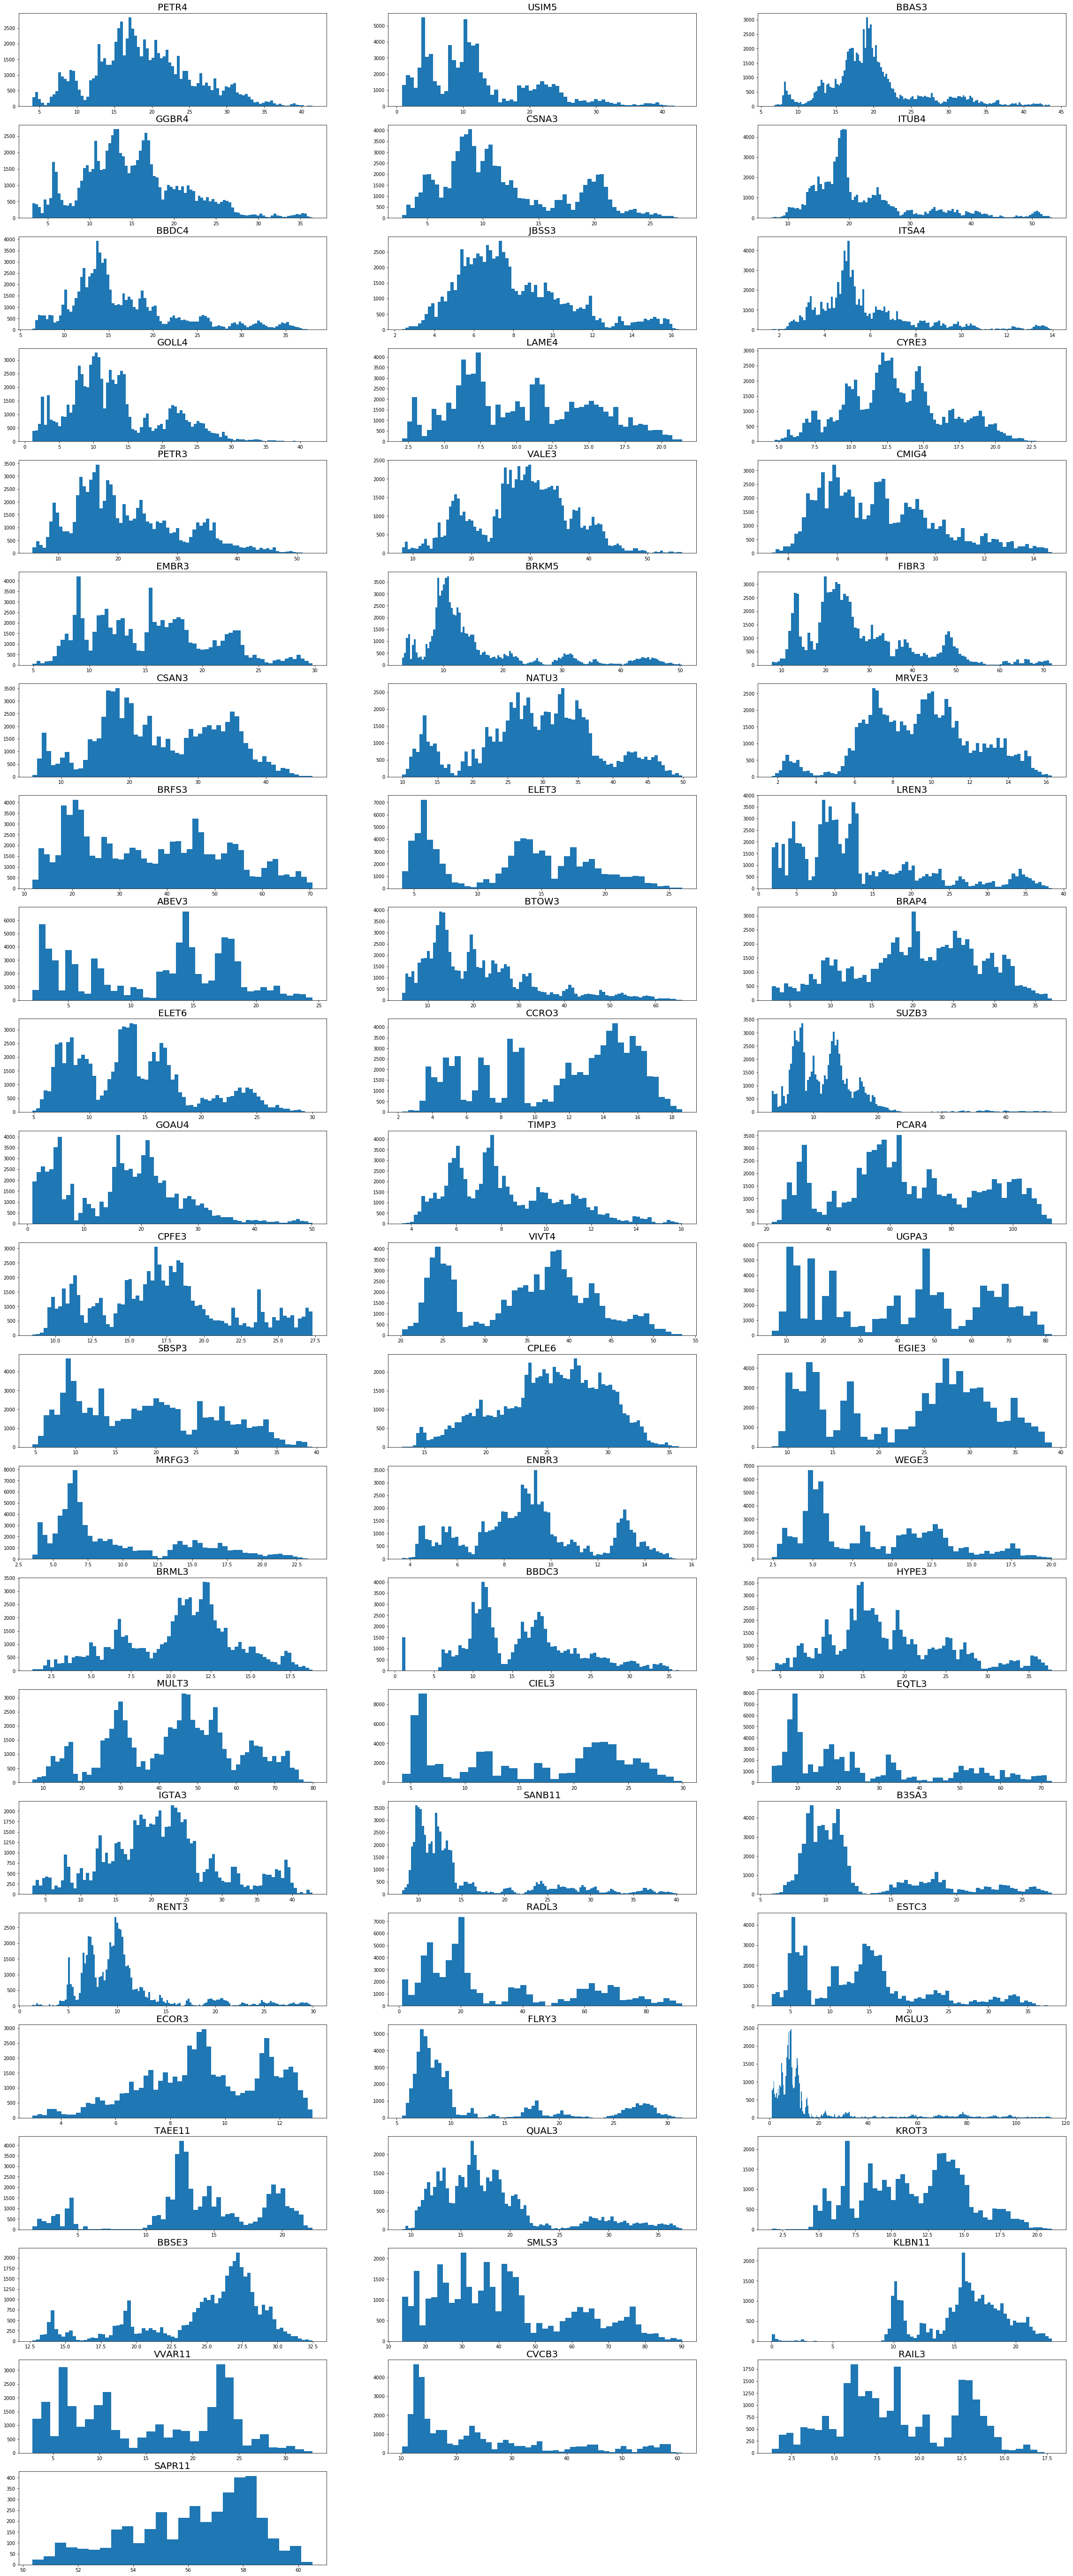

In [4]:
def plot_histogram(data, plt, log=False):
    plt.hist(x=data, bins='auto', log=log)#, color='#0504aa', alpha=0.7, rwidth=0.85)

def plot_all_histograms(sorted_grouped_data, plt, attr, log=False):
    i = 1
    PLT_COLUMNS = 3
    PLT_ROWS = len(grouped_data)//PLT_COLUMNS+1
    
    plt.figure(figsize=(40, 100))


    for stock_code, stock_code_data in sorted_grouped_data:
        # fit histogram into the grid
        plt.subplot(PLT_ROWS, PLT_COLUMNS, i)
        i += 1
        # generate the histogram
        plot_histogram(stock_code_data[attr], plt, log)
        plt.title(stock_code, fontsize=20)

plot_all_histograms(sorted_grouped_data, plt, "fechamento_atual")
plt.show()

Observem as caldas que algumas séries possuem:

In [5]:
codigos = ["MGLU3","PETR4","VALE3"]
full_data = full_data[full_data.codigo.isin(codigos)]
#Seleciona apenas data
full_data["datadia"] = full_data.datahora.dt.date
grouped_data = full_data.groupby("codigo", as_index=False)    

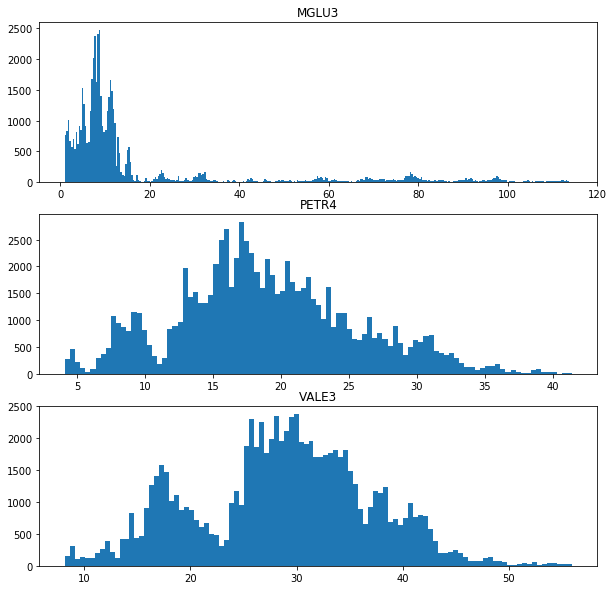

In [6]:
#Plot separado das 3 ações escolhidas
i = 1
plt.figure(figsize=(10, 10))
for codigo in codigos:
    plt.subplot(3,1,i)
    plot_histogram(grouped_data.get_group(codigo)["fechamento_atual"], plt)
    plt.title(codigo)
    i+=1
plt.show()

In [7]:
#Verifica a existencia de valores de fechamento = 0
import numpy as np

for codigo in codigos:
    d = grouped_data.get_group(codigo)
    x = np.log(d["fechamento_atual"]) - np.log(d["fechamento_anterior"])

    before_removing_invalid_values = len(x)
    x = x[np.isfinite(x)]
    print("{} removed {}".format(codigo,str(before_removing_invalid_values - len(x))))

MGLU3 removed 5
PETR4 removed 4
VALE3 removed 5


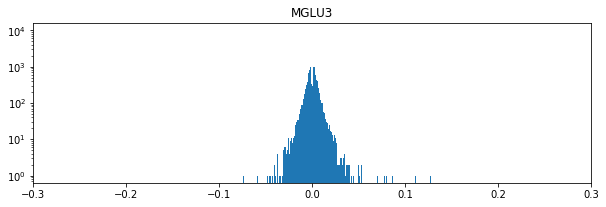

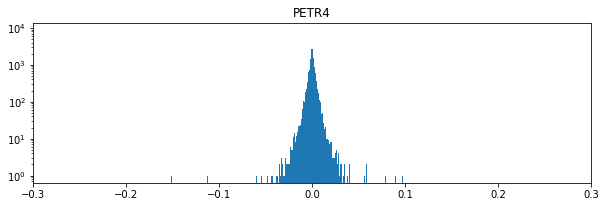

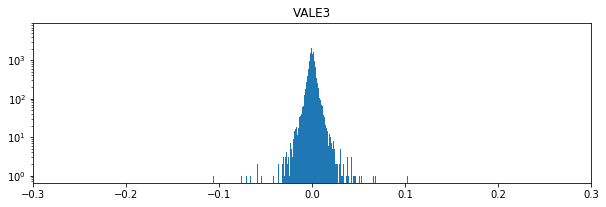

In [8]:
def get_log_return(data):
    log_return = np.log(data["fechamento_atual"]) - np.log(data["fechamento_atual"].shift(1))
    log_return.loc[log_return.head(1).index] = 0.0
    return log_return

def remove_first_element(data):
    data.drop(log_return.index[:1], inplace=True)
    
i = 1
for codigo in codigos:
    plt.figure(figsize=(10, 10))
    plt.subplot(3,1,i)
    i+=1
    log_return = get_log_return(grouped_data.get_group(codigo))
    # delete shifted elements as it is NaN
    # remove_first_element(log_return)
    # another way to do that: x = x[np.isfinite(x)]

    plot_histogram(log_return, plt, log=True)
    plt.xlim(-0.3,0.3)
    plt.title(codigo)
plt.show()

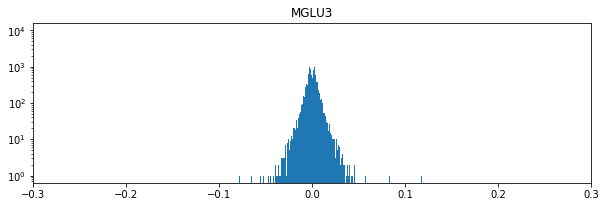

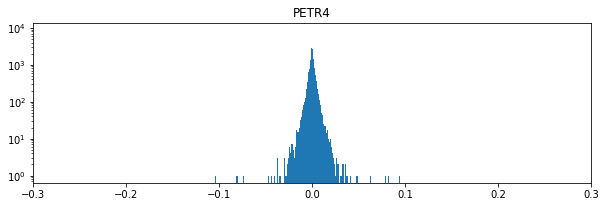

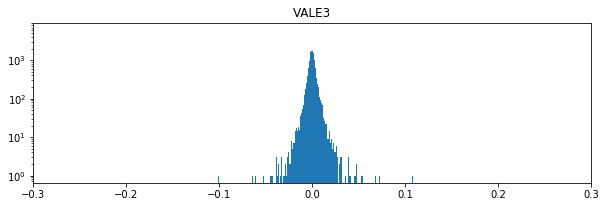

In [9]:
#Calcula retorno simples = fechamento_atual - fechamento_anterior / fechamento_anterior

def get_simple_return(data):
    #Faz shift do fechamento atual, primeiro valor passa a ser NaN
    previous_closes = data["fechamento_atual"].shift(1)
    
    current_closes = data["fechamento_atual"]
    
    x = (current_closes - previous_closes)

    simple_return = np.divide(x, previous_closes)
    
    # adiciona primeiro retorno como zero, por causa do shift
    simple_return.loc[simple_return.head(1).index] = 0.0
    
    return simple_return


i = 1
for codigo in codigos:
    plt.figure(figsize=(10, 10))
    plt.subplot(3,1,i)
    simple_return = get_simple_return(pd.DataFrame(grouped_data.get_group(codigo)))
    if i == 1:
        list_simple_return = simple_return
    else:    
        list_simple_return = np.append(list_simple_return, simple_return)
    i+=1
    plot_histogram(simple_return, plt, log=True)
    plt.xlim(-0.3, 0.3)
    plt.title(codigo)
plt.show()

In [12]:
full_data["simple_return"] = list_simple_return

# Candle básico
Disponível <a href="https://plot.ly/python/candlestick-charts/">aqui</a>.

In [13]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='username', api_key='apikey')

In [14]:
data_mgl = full_data[full_data.codigo == "MGLU3"]

data_mgl.set_index("datahora", inplace=True)

open_mgl =  data_mgl.abertura.resample('D', how='first')
high_mgl =  data_mgl.maximo.resample('D', how='max')
low_mgl =  data_mgl.minimo.resample('D', how='min')
close_mgl =  data_mgl.fechamento_atual.resample('D', how='last')
volume_mgl = data_mgl.volume_financeiro.resample('D', how='sum')
negocios_mgl = data_mgl.negocios.resample('D', how='sum')
qnt_papeis_mgl = data_mgl.quantidade_papeis.resample('D', how='sum')
simp_return_mgl = data_mgl.simple_return.resample('D', how='sum')

data_mgl = pd.concat([open_mgl,high_mgl,low_mgl,close_mgl,volume_mgl,negocios_mgl,qnt_papeis_mgl,simp_return_mgl], axis=1)
data_mgl.dropna(inplace=True)
data_mgl.head()

,abertura,maximo,minimo,fechamento_atual,volume_financeiro,negocios,quantidade_papeis,simple_return
datahora,,,,,,,,
2011-05-02,15.01,15.47,15.01,15.33,143468804.0,9095,8750100,0.019250
2011-05-03,15.37,15.56,15.08,15.18,17392996.0,1619,1063200,-0.009523
2011-05-04,15.20,15.36,15.20,15.26,20178219.0,1168,1231900,0.005352
2011-05-05,15.29,15.29,15.16,15.16,18256498.0,827,1114600,-0.006509
2011-05-06,15.23,15.26,14.91,15.01,19709202.0,1111,1211000,-0.009733


In [17]:
trace = go.Candlestick(x=data_mgl.index,
                       open=data_mgl.abertura,
                       high=data_mgl.maximo,
                       low=data_mgl.minimo,
                       close=data_mgl.fechamento_atual)
data = [trace]

layout = {
    'title': 'MGLU3',
    'yaxis': {'title': 'MGLU3 Stock'},
    'shapes': [{
        'x0': '2016-08-31', 'x1': '2016-08-31',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2016-08-31', 'y': 0.9, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': 'Impeachment Dilma'
    }]}



fig = dict(data=data, layout=layout)
    
py.iplot(fig, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~iagoadvaz/0 or inside your plot.ly account where it is named 'simple_candlestick'


# Novo Exemplo
Disponível <a href="https://plot.ly/~jackp/17421.embed">aqui</a>.

### Inicializa o candlestick

In [27]:
INCREASING_COLOR = '#17BECF'
DECREASING_COLOR = '#7F7F7F'

data = [ dict(
    type = 'candlestick',
    open = data_mgl.abertura,
    high = data_mgl.maximo,
    low = data_mgl.minimo,
    close = data_mgl.fechamento_atual,
    x = data_mgl.index,
    yaxis = 'y2',
    name = 'GS',
    #increasing = dict( line = dict( color = INCREASING_COLOR ) ),
    #decreasing = dict( line = dict( color = DECREASING_COLOR ) ),
) ]

layout=dict()

fig = dict( data=data, layout=layout )

### Cria o objeto de layout

In [28]:
fig['layout'] = dict()
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )

### Adciona botões de range

In [29]:
rangeselector=dict(
    visibe = True,
    x = 0, y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict( size = 13 ),
    buttons=list([
        dict(count=1,
             label='reset',
             step='all'),
        dict(count=1,
             label='1yr',
             step='year',
             stepmode='backward'),
        dict(count=3,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
    
fig['layout']['xaxis']['rangeselector'] = rangeselector

### Adciona média móvel

In [30]:
def movingaverage(interval, window_size=10):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [31]:
mv_y = movingaverage(data_mgl.fechamento_atual)
mv_x = list(data_mgl.index)

# Clip the ends
mv_x = mv_x[5:-5]
mv_y = mv_y[5:-5]

fig['data'].append( dict( x=mv_x, y=mv_y, type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#E377C2' ),
                         yaxis = 'y2', name='Moving Average' ) )

### Define as cores do gáfico de barras de volume

In [32]:
colors = []

for i in range(len(data_mgl.fechamento_atual)):
    if i != 0:
        if data_mgl.fechamento_atual[i] > data_mgl.fechamento_atual[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)

### Adciona gráfico de barras de volume

In [33]:
fig['data'].append( dict( x=data_mgl.index, y=data_mgl.volume_financeiro,                         
                         marker=dict( color=colors ),
                         type='bar', yaxis='y', name='Volume' ) )

### Adciona bollinger bands

In [35]:
def bbands(price, window_size=10, num_of_std=5):
    rolling_mean = price.rolling(window=window_size).mean()
    rolling_std  = price.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)
    return rolling_mean, upper_band, lower_band

bb_avg, bb_upper, bb_lower = bbands(data_mgl.fechamento_atual)

fig['data'].append( dict( x=data_mgl.index, y=bb_upper, type='scatter', yaxis='y2', 
                         line = dict( width = 1 ),
                         marker=dict(color='#ccc'), hoverinfo='none', 
                         legendgroup='Bollinger Bands', name='Bollinger Bands') )

fig['data'].append( dict( x=data_mgl.index, y=bb_lower, type='scatter', yaxis='y2',
                         line = dict( width = 1 ),
                         marker=dict(color='#ccc'), hoverinfo='none',
                         legendgroup='Bollinger Bands', showlegend=False ) )

### Plot

In [36]:
py.iplot( fig, filename = 'candlestick-test-3', validate = False )